## LivingEarth LCCS - Test Notebook

Notebook to test things out while developing LivingEarth LCCS software

In [1]:
import numpy
import xarray
import scipy
from matplotlib import pyplot

Import LivingEarth LCCS modules from https://bitbucket.org/au-eoed/livingearth_lccs/
The git checkout needs to be on your PYTHONPATH using:

```
export PYTHONPATH=/path/to/livingearth_lccs:$PYTHONPATH
```
before opening the notebook or edit and run the line below

In [2]:
import sys
sys.path.append("../../../livingearth_lccs")

In [3]:
# Import le_lccs modules
from le_lccs import le_ingest
from le_lccs.le_classification import lccs_l3

## Data input

Data are read from GDAL files for testing, would get data from ODC in final system

Set up dictionary with variables and their source. In the code design this information would be read from a config file.

In [4]:
variables_files = {
    "vegetat_veg_cat" : "data/L3Vegetat.kea",
    "aquatic_wat_cat" : "data/L3Aquatic.kea",
    "cultman_agr_cat" : "data/L3Cultman.kea",
    "artific_urb_cat" : "data/L3Urbanis.kea",
    "artwatr_wat_cat" : "data/L3Artwatr.kea"
}

Create latitude and longitude arrays which will be used to subset and resample the input data.
For this test use `aquatic_wat_cat` as know this is the smallest layer

In [5]:
extent_ds = xarray.open_rasterio(variables_files["aquatic_wat_cat"])

x_coords = extent_ds.coords["x"]
y_coords = extent_ds.coords["y"]

out_crs = extent_ds.attrs['crs'].replace("+init=","").upper()
extent_ds = None

Now load all data to a list of xarrays.

The planned code will use a config file to define each variable which will include information such as the function used to read the data, this can be a built in function or a user defined one which may perform some pre-processing.

Other variables will be dependent on the function but are expected to include things like 'variable_name'.

The xarray for each variable contains a three dimentional array (band, y, x) with data values.

In [6]:
variables_xarray_list = []
for var_name, var_file in variables_files.items():
    try:
        # Set up a dictionary of the parameters for each variable.
        # This will eventually be read from a config file
        ingest_parameters = {"import_class_name" : "gridded_ingest.LEIngestGDAL",
                             "input_file" : var_file, "variable_name" : var_name, 
                             "x_coords" : x_coords, "y_coords" : y_coords}

        # Get the class to use for importing
        # Need to write a wapper to make reccursive calls of `getattr` nicer.
        import_class_name = ingest_parameters["import_class_name"]
        ImportClass = getattr(getattr(le_ingest, import_class_name.split(".")[0]), import_class_name.split(".")[1])
        import_obj = ImportClass(x_coords, y_coords, target_crs=out_crs)
               
        # Import and append to list
        variables_xarray_list.append(import_obj.read_to_xarray(**ingest_parameters))
    except IOError as err:
        # If file can't be loaded print error but continue.
        # Need to deal with missing layers in classification
        print(err)

## Classification

The LCCS classificaition is hierachial. The 8 classes are shown below.

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |

The previous code dealt with missing layers by setting all values to 0 and then using this in the classification. This could cause problems. For example with the missing `artwatr_wat_cat` layer all values would be 0 so all water would be assigned a supercatergory of 'Natural Water (B28)'. In this system Artifical Water and Natural water would both be assigned 0 in the Level 3 classification but values for Level 2 would be stored.

In [7]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)

Before running the classification can look at some of the input layers using the matplotlib `imshow` function. Although quite limited it works as a quick check that the data layers have been read in OK

In [8]:
expstr = "vegetat_veg_cat * 100"
expr_vars = {"vegetat_veg_cat" : classification_data["vegetat_veg_cat"], "aquatic_wat_cat" : classification_data["aquatic_wat_cat"]}
expr_out = eval(expstr, {}, expr_vars)
#expr_out = expr_out.rename({"band" : "expr_result"})
expr_out.to_dataset(name="expr_result")


<xarray.Dataset>
Dimensions:      (band: 1, x: 3992, y: 3138)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.491e+05 3.491e+05 3.491e+05 ... 3.89e+05 3.89e+05
  * y            (y) float64 5.06e+06 5.06e+06 5.06e+06 ... 5.029e+06 5.029e+06
Data variables:
    expr_result  (band, y, x) float64 100.0 100.0 100.0 100.0 ... 1.625 0.0 0.0

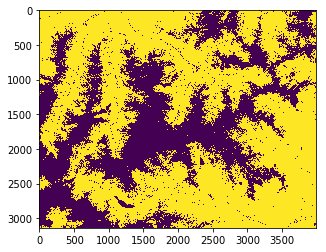

In [9]:
pyplot.imshow(classification_data["vegetat_veg_cat"][0])

### Apply classification

Apply Level 3 classification using separate function. Works through in three stages and saves final class to "Supercategory".

In [10]:
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

### Display output

To check the results can use matplotlib to show an image. Use `colour_lccs_level3` to get the colour scheme.

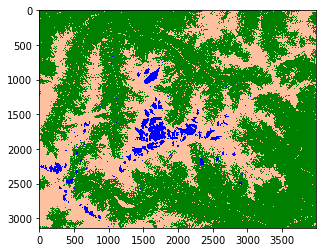

In [11]:
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3[0])
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

In [12]:
# Check classses within scene.
numpy.unique(level3)

array([112, 124, 216, 228], dtype=uint8)

### Save classification values back to xarray

In [13]:
out_class_xarray = xarray.Dataset({"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
                                   "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
                                   "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])

### Save to a netCDF file

Specify NETCDF4 as this supports unsigned integers. For this to work need to have netCDF4 library installed.

In [14]:
classification_data.to_netcdf("data/classification_data.nc", format="NETCDF4")

Load back in as a dask array by specifying chunks

In [15]:
classification_data_nc = xarray.open_dataset("data/classification_data.nc", chunks={"x" : 100, "y" : 100})

In [16]:
classification_data_nc

<xarray.Dataset>
Dimensions:          (band: 1, x: 3992, y: 3138)
Coordinates:
  * band             (band) int64 1
  * x                (x) float64 3.491e+05 3.491e+05 ... 3.89e+05 3.89e+05
  * y                (y) float64 5.06e+06 5.06e+06 ... 5.029e+06 5.029e+06
Data variables:
    vegetat_veg_cat  (band, y, x) float64 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    aquatic_wat_cat  (band, y, x) int16 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    cultman_agr_cat  (band, y, x) float64 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    artific_urb_cat  (band, y, x) float64 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    artwatr_wat_cat  (band, y, x) float64 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    level1           (band, y, x) uint8 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    level2           (band, y, x) uint8 dask.array<shape=(1, 3138, 3992), chunksize=(1, 100, 100)>
    level3        

In [17]:
# Close
classification_data_nc.close()